In [1]:
import os
# Define dataset path
dataset_path = "geotiffs"

# Example: Disaster-specific folder
tier_folder = os.path.join(dataset_path, "tier1")
images_folder = os.path.join(tier_folder, "images")
labels_folder = os.path.join(tier_folder, "labels")


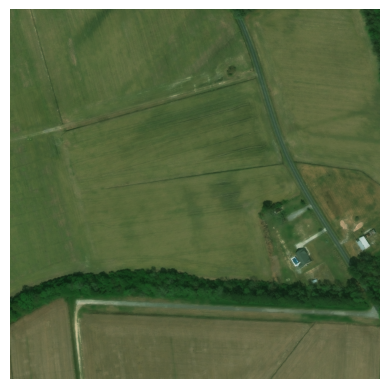

{
    "features": {
        "lng_lat": [
            {
                "properties": {
                    "feature_type": "building",
                    "uid": "8b78dbe3-d082-41e0-abf3-4c06eb99270d"
                },
                "wkt": "POLYGON ((-77.93974254710972 34.56770271107827, -77.93966091613942 34.56761075076842, -77.93972316340545 34.56757026726694, -77.93974702288374 34.56757039695101, -77.93977193996783 34.56755217738122, -77.93980544934283 34.56758614196894, -77.93980509609661 34.56759394338734, -77.93984146150181 34.56762787516347, -77.93983653286949 34.56763059159534, -77.93986715040529 34.56766330932185, -77.93981297535709 34.56770253005008, -77.93975550957526 34.56772165456024, -77.93974254710972 34.56770271107827))"
            },
            {
                "properties": {
                    "feature_type": "building",
                    "uid": "6abee917-faa1-4bd8-a82b-d7599f3f9ec9"
                },
                "wkt": "POLYGON ((-77.93964769167418 34.

In [2]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy
import json

imageID = "hurricane-florence_00000059_pre_disaster"

# Load a sample image
image_file = os.path.join(images_folder, f"{imageID}.tif")
image = tiff.imread(image_file)

# Display the image
plt.imshow(image)
plt.axis("off")
plt.show()

# Load label JSON file
label_file = os.path.join(labels_folder, f"{imageID}.json")
with open(label_file, "r") as f:
    label_data = json.load(f)

# Print label information
print(json.dumps(label_data, indent=4))


## ResNet50 Model Clas

In [2]:
import os
import json
import random
import numpy as np
import tifffile as tiff
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the disaster labels mapping
disaster_labels = {
    'volcano': 1,
    'fire': 2,
    'tsunami': 3,
    'flooding': 4,
    'earthquake': 5,
    'wind': 6
}

2025-04-20 20:33:25.209786: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-20 20:33:26.143049: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 20:33:27.280896: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 20:33:27.282226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-20 20:33:29.950925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
# Function to safely load and preprocess TIF files
def load_and_preprocess_tif(tif_path, target_size=(224, 224)):
    """
    Load and preprocess a TIF image for the ResNet model.
    """
    try:
        # Load the TIF file
        img = tiff.imread(tif_path)
        
        # Handle grayscale images (single channel)
        if len(img.shape) == 2:
            img = np.stack((img,) * 3, axis=-1)
        # Handle multi-band images with more than 3 channels
        elif len(img.shape) == 3 and img.shape[2] > 3:
            img = img[:, :, :3]
        
        # Ensure proper dimensions
        if not (img.shape[0] > 0 and img.shape[1] > 0 and img.shape[2] == 3):
            print(f"Invalid image shape {img.shape} for {tif_path}")
            return None
        
        # Convert 16-bit to 8-bit if needed
        if img.dtype == np.uint16:
            img = (img / 65535.0 * 255.0).astype(np.uint8)
        
        # Resize to target size
        img = tf.image.resize(img, target_size)
        
        # Apply ResNet-specific preprocessing
        img = preprocess_input(img.numpy())
        
        return img
    
    except Exception as e:
        print(f"Error processing image {tif_path}: {e}")
        return None
    
    

In [4]:
def extract_disaster_label(data):
    """
    Extract the disaster type label from JSON data.
    Returns None if not a post-disaster image.
    """
    try:
        # Check if it's a post-disaster image
        img_name = data['metadata'].get('img_name', '').lower()
        if '_post_disaster' not in img_name:
            return None

        disaster_type = data['metadata']['disaster_type']
        label = disaster_labels.get(disaster_type)
        
        if label is not None:
            return label - 1  # Convert to 0-based index
        else:
            print(f"Unknown disaster type: {disaster_type}")
            return None
            
    except Exception as e:
        print(f"Error extracting label: {e}")
        return None

def load_dataset(base_path, tiers, sample_fraction=0.1, seed=42):
    """
    Load and preprocess a subset of the disaster dataset (post-disaster only).
    """
    random.seed(seed)
    images = []
    labels = []
    file_paths = []
    
    for tier in tiers:
        images_dir = os.path.join(base_path, tier, 'images')
        labels_dir = os.path.join(base_path, tier, 'labels')
        
        if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
            continue
            
        tif_files = [f for f in os.listdir(images_dir) if f.lower().endswith('.tif')]
        num_samples = max(1, int(len(tif_files) * sample_fraction))
        sampled_files = random.sample(tif_files, num_samples)
        
        for tif_file in sampled_files:
            tif_path = os.path.join(images_dir, tif_file)
            json_path = os.path.join(labels_dir, tif_file.replace('.tif', '.json'))
            
            if not os.path.exists(json_path):
                continue
                
            try:
                with open(json_path, 'r') as f:
                    data = json.load(f)
            except Exception as e:
                continue
                
            label = extract_disaster_label(data)
            if label is None:  # Automatically skips pre-disaster images
                continue
                
            img = load_and_preprocess_tif(tif_path)
            if img is None:
                continue
                
            images.append(img)
            labels.append(label)
            file_paths.append(tif_path)
    
    return np.array(images), np.array(labels), file_paths

In [5]:
# Function to create ResNet model
def create_resnet_model(num_classes=6, input_shape=(224, 224, 3)):
    """
    Create a ResNet-based model for disaster classification.
    """
    # Load pre-trained ResNet50 as base model
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze early layers for transfer learning
    for layer in base_model.layers[:-15]:  # Fine-tune only the last 15 layers
        layer.trainable = False
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [6]:
# Function to train the model
def train_model(train_data, val_data, epochs=20, batch_size=16):
    """
    Train the disaster classification model.
    """
    X_train, y_train = train_data
    X_val, y_val = val_data
    
    # Create the model
    model = create_resnet_model()
    
    # Define callbacks
    callbacks = [
        ModelCheckpoint(
            'best_disaster_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

In [7]:
# Function to predict disaster type
def predict_disaster_type(model, tif_path):
    """
    Predict the disaster type for a given TIF image.
    """
    try:
        # Load and preprocess the image
        img = load_and_preprocess_tif(tif_path)
        if img is None:
            return "Error processing image", 0.0
        
        # Add batch dimension
        img = np.expand_dims(img, axis=0)
        
        # Make prediction
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction[0])
        confidence = float(prediction[0][predicted_class])
        
        # Convert index to disaster type name
        disaster_types = {v-1: k for k, v in disaster_labels.items()}
        predicted_type = disaster_types.get(predicted_class, "Unknown")
        
        return predicted_type, confidence
    
    except Exception as e:
        print(f"Error during prediction: {e}")
        return "Error", 0.0

In [8]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """Plot training and validation loss curves from training history."""
    plt.figure(figsize=(10, 6))
    
    # Plot training loss
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
    
    # Plot validation loss
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
    
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Main execution function
def main():
    """Main function to train and evaluate the disaster classification model."""
    # Set seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)
    
    base_path = 'geotiffs'
    sample_fraction = 1  # Use 10% of the data as specified
    
    try:
        # Load datasets
        print("Loading training data...")
        train_images, train_labels, train_paths = load_dataset(
            base_path, ['tier1', 'tier3'], sample_fraction
        )
        
        print("Loading validation data...")
        val_images, val_labels, val_paths = load_dataset(
            base_path, ['hold'], sample_fraction
        )
        
        print("Loading test data...")
        test_images, test_labels, test_paths = load_dataset(
            base_path, ['test'], sample_fraction
        )
        
        print(f"Dataset loaded: {len(train_images)} training, "
              f"{len(val_images)} validation, {len(test_images)} test samples")
        
        # Train the model
        print("Training model...")
        model, history = train_model(
            (train_images, train_labels),
            (val_images, val_labels)
        )
        
        # Evaluate on test set
        print("Evaluating model on test data...")
        test_loss, test_accuracy = model.evaluate(test_images, test_labels)
        print(f"Test accuracy: {test_accuracy * 100:.2f}%")
        
        # Save the model
        model.save('disaster_classification_model.keras')
        print("Model saved as 'disaster_classification_model.h5'")
        
        print("Plotting training metrics...")
        plot_loss_curves(history)
        
        # Example prediction
        if test_paths:
            example_path = test_paths[0]
            predicted_type, confidence = predict_disaster_type(model, example_path)
            
            print(f"Example prediction on {os.path.basename(example_path)}:")
            disaster_types = {v-1: k for k, v in disaster_labels.items()}
            true_type = disaster_types[test_labels[0]]
            print(f"True disaster type: {true_type}")
            print(f"Predicted disaster type: {predicted_type} (confidence: {confidence:.2f})")
            
        
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

Loading training data...
Loading validation data...
Loading test data...
Dataset loaded: 9168 training, 933 validation, 933 test samples
Training model...
